University of Helsinki, Master's Programme in Mathematics and Statistics  
MAST32001 Computational Statistics, Autumn 2023  
Luigi Acerbi  
Based on notebook by Antti Honkela 

# Lecture 6: Markov chain Monte Carlo (MCMC) basics

Background reading: please see Chapter 6 of the "Course notes" available in Moodle.


## 1. Metropolis-Hastings sampling of a 1D target

1. Write a Metropolis-Hastings sampler to draw samples having as target density the standard normal distribution (zero mean, unit variance) $\mathcal{N}(0, 1)$, using the following proposal distribution: $$Q(\theta^\prime ; \theta) = \mathrm{Uniform}(\theta^\prime; \theta-0.5, \theta+0.5).$$ Draw 1000 samples and compute the acceptance rate of your sampler.
2. Throw away the first half of the samples (warmup), from now on we only consider the second half. Plot a normalized (`density=True`) histogram of the samples you have drawn together with the true density. *Hint*: For a 1D array `a`, you can throw away the first half with `a = a[len(a)//2:]`.
3. Plot a trace plot of the samples: a line plot of the samples (*Hint*: Simply use `plt.plot`). Do consecutive samples appear independent or are they correlated? Plot a similar trace of the samples when they are permuted to a random order. Do the curves look simiar?
4. Try increasing the number of samples to 10000 and only including every 10th sample in the plots. This is called *thinning*. (*Hint*: you can extract every 10th element of a numpy.array `theta` using `theta[::10]`.)
5. Try changing the bounds of the proposal distribution such that they remain symmetric about $\theta$, run the sampler and redraw the plots. Can you make the samples appear more independent? Is there a connection between the acceptance rate and the appearance of the plots?
6. Compute the expectation $E[\theta^2]$ using your samples using the Monte Carlo approximation
$$ E[f(\theta)] \approx \frac{1}{n} \sum_{i=1}^n f(\theta_i) \quad \Longrightarrow \quad E[\theta^2] \approx \frac{1}{n} \sum_{i=1}^n (\theta_i)^2, $$
where $\theta_i, i = 1, \dots, n$ are the samples you have drawn. Compare the value you obtained with the known ground truth (i.e., the second moment of a standard normal distribution).

In [1]:
%matplotlib inline
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt

npr.seed(41)

def mhsample(theta0, n, log_target, drawproposal):
    """
    Metropolis-Hastings sampler for n samples from starting point theta0.
    log_target is the log of the target pdf, and 
    drawproposal samples from the proposal (assumed symmetric).
    """
    theta = theta0
    accepts = 0
    lp = log_target(theta)
    thetas = np.zeros(n)
    for i in range(n):
        theta_prop = drawproposal(theta)
        l_prop = log_target(theta_prop)
        if np.log(npr.rand()) < l_prop - lp:
            theta = theta_prop
            lp = l_prop
            accepts += 1
        thetas[i] = theta
    print('Acceptance rate:', accepts/n)
    return thetas

def normal_pdf(x, mu, sigma):
    """Normal distribution pdf with given mean mu and standard deviation sigma."""
    return np.exp(-(x-mu)**2/(2*sigma**2))/(np.sqrt(2*np.pi)*sigma)

# Note that now Q(theta',theta^(t)) = Q(theta^(t), theta') so we do not need to include Q(theta'; theta) term for the acceptance probability


# 1

 # Metropolis-Hastings does not care about additive constants of the log-density, so we can ignore them
logpdf = lambda theta: -0.5*theta**2
proposal = lambda theta: theta+(npr.rand()-0.5)
theta = mhsample(0.0, 1000, logpdf, proposal)

Acceptance rate: 0.905


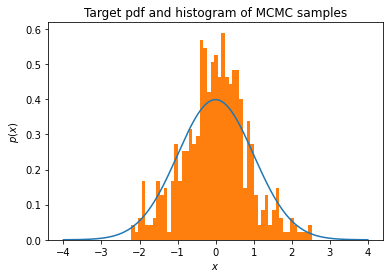

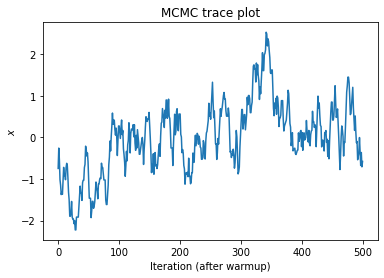

In [2]:
def make_plots(theta,thin=1):
    """Make diagnostics plots for MCMC."""
    x = np.linspace(-4, 4, 1000)
    plt.plot(x, normal_pdf(x, 0.0, 1.0))
    plt.hist(theta[::thin], bins=50, density=True)
    plt.xlabel(r'$x$')
    plt.ylabel(r'$p(x)$')
    plt.title(r'Target pdf and histogram of MCMC samples')
    plt.show()

    plt.plot(theta[::thin])
    plt.xlabel(r'Iteration (after warmup)')
    plt.ylabel(r'$x$')
    plt.title(r'MCMC trace plot')
    plt.show()    

# 2-3
theta = theta[len(theta)//2:]  # warmup: throw away first half of the samples
make_plots(theta,thin=1)

Acceptance rate: 0.9002


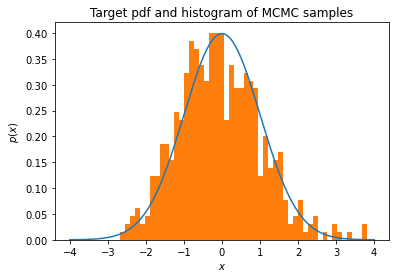

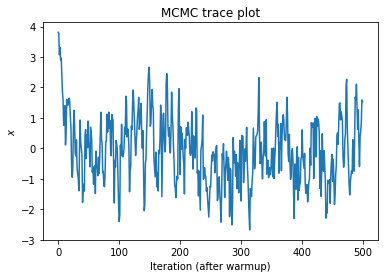

In [3]:
# 4
theta = mhsample(0.0, 10000, logpdf, proposal)
theta = theta[len(theta)//2:]  # warmup: throw away first half of the samples
make_plots(theta,thin=10)

Acceptance rate: 0.3207


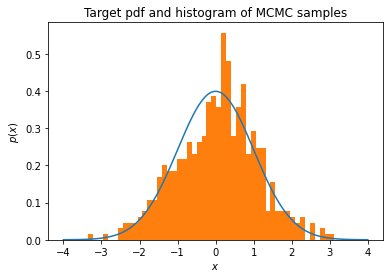

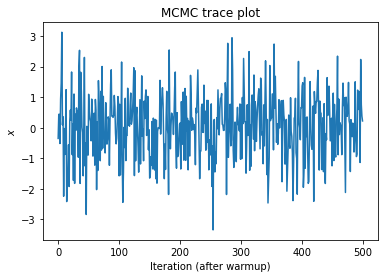

E[theta^2] = 1.064742106906927 (theoretical value = 1.0).


In [4]:
# 5
wider_proposal = lambda theta: theta+10*(npr.rand()-0.5)
theta = mhsample(0.0, 10000, logpdf, wider_proposal)
theta = theta[len(theta)//2:]  # warmup: throw away first half of the samples
make_plots(theta,thin=10)

# 6
print("E[theta^2] =", np.mean(theta**2), "(theoretical value = 1.0).")

## 2. Tuning a Metropolis-Hastings sampler

Let us consider Metropolis-Hastings sampling of a $\mathcal{N}(0, 1)$ target with $$q(\theta', \theta) = \mathcal{N}(\theta';\; \theta, \sigma^2)$$ as the proposal. Your aim is to tune the proposal width $\sigma > 0$ to obtain optimal mixing.

1. Implement the sampler and run it 20 times with a number of different values of $\sigma$. Record the acceptance rates and the mean and variance of the samples you obtain. What value of $\sigma$ gives the most accurate estimates? What is the corresponding acceptance rate?
2. Repeat the task with $q(\theta', \theta) = \mathrm{Uniform}(\theta-\sigma/2, \theta+\sigma/2)$ as the proposal.  What value of $\sigma$ now gives the most accurate estimates? What is the corresponding acceptance rate?

In [5]:
%matplotlib inline
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt

npr.seed(41)

# return acceptance rate to avoid too many prints
def mhsample(theta0, n, log_target, drawproposal):
    """
    Metropolis-Hastings sampler for n samples from starting point theta0.
    log_target is the log of the target pdf, and 
    drawproposal samples from the proposal (assumed symmetric).
    """
    theta = theta0
    accepts = 0
    lp = log_target(theta)
    thetas = np.zeros(n)
    for i in range(n):
        theta_prop = drawproposal(theta)
        l_prop = log_target(theta_prop)
        if np.log(npr.rand()) < l_prop - lp:
            theta = theta_prop
            lp = l_prop
            accepts += 1
        thetas[i] = theta
    return thetas, accepts/n

def sample_normal(nsamples, repeats, drawproposal):
    """Sample from a standard normal via Metropolis-Hastings for repeats times using drawproposal."""
    means = np.zeros(repeats)
    stds = np.zeros(repeats)
    accepts = np.zeros(repeats)
    for i in range(repeats):
        theta, accepts[i] = mhsample(0.0, 10000, lambda theta: -0.5*theta**2, drawproposal)
        # Drop warm-up samples
        theta = theta[len(theta)//2:]
        means[i] = np.mean(theta)
        stds[i] = np.std(theta)
    return means, stds, np.mean(accepts)

def check_errors(means, stds, truemean=0.0, truestd=1.0):
    """Compute errors from ground truth mean and standard deviations."""
    return (np.sqrt(np.mean((means-truemean)**2)), np.sqrt(np.mean((stds-truestd)**2)))

npr.seed(42)
widths = [0.1, 0.3, 1.0, 3.0, 10.0, 30.0]
n_times = 20

for w in widths:
    means, stds, accepts = sample_normal(10000, n_times, lambda theta: theta+w*npr.normal())
    meanerr, stderr = check_errors(means, stds)
    print('normal width %.1f' % w, 'acceptance rate', accepts,
          'mean RMSE', meanerr, 'std RMSE', stderr)

print()
    
for w in widths:
    means, stds, accepts = sample_normal(10000, n_times, lambda theta: theta+w*(npr.random()-0.5))
    meanerr, stderr = check_errors(means, stds)
    print('uniform width %.1f' % w, 'acceptance rate', accepts,
          'mean RMSE', meanerr, 'std RMSE', stderr)


normal width 0.1 acceptance rate 0.9697799999999999 mean RMSE 0.27274116683503147 std RMSE 0.14185883418539214
normal width 0.3 acceptance rate 0.9045599999999998 mean RMSE 0.07196590014633435 std RMSE 0.05719382798237671
normal width 1.0 acceptance rate 0.705295 mean RMSE 0.049476429605960374 std RMSE 0.027947065527429326
normal width 3.0 acceptance rate 0.37493499999999996 mean RMSE 0.04282476758413724 std RMSE 0.0312471067955582
normal width 10.0 acceptance rate 0.124895 mean RMSE 0.043540548529469696 std RMSE 0.0351115499043509
normal width 30.0 acceptance rate 0.04182000000000001 mean RMSE 0.07871812343363212 std RMSE 0.069092507664198

uniform width 0.1 acceptance rate 0.9905149999999999 mean RMSE 0.6277376288228592 std RMSE 0.404145508448284
uniform width 0.3 acceptance rate 0.9709300000000001 mean RMSE 0.4188331615019112 std RMSE 0.13935667438835342
uniform width 1.0 acceptance rate 0.900995 mean RMSE 0.13393358355046903 std RMSE 0.06684859357179027
uniform width 3.0 acceptance

## 3. Metropolis-Hastings sampling of a higher dimensional target

1. Implement a Metropolis-Hastings sampler for multivariate targets and test it for sampling from the standard zero-mean, unit covariance $d$-dimensional multivariate normal $\mathcal{N}(0, I_d)$ for $d = 2$ using $Q(\theta' ; \theta) = \mathcal{N}(\theta' ;\; \theta, w I_d)$ as the proposal with $w = 0.5$. Draw 10000 samples and thin by a factor of 10.
2. Plot trace plots, histograms and pairwise scatter plots of all pairs of variables.
3. Run the sampler and draw the plots again with different $w$. How do the results change? Can you see the link between the acceptance ratio and the appearence of the plots?
4. Repeat the analysis for $d=5$.

In [6]:
%matplotlib inline
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt

npr.seed(41)

#1
def d_mhsample(theta0, n, log_target, drawproposal):
    """
    Metropolis-Hastings sampler for n samples from starting point theta0 in arbitrary dimension.
    log_target is the log of the target pdf, and 
    drawproposal samples from the proposal (assumed symmetric).
    """    
    theta = theta0
    d = len(theta0)
    accepts = 0
    lp = log_target(theta)
    thetas = np.zeros([n, d])
    for i in range(n):
        theta_prop = drawproposal(theta)
        l_prop = log_target(theta_prop)
        if np.log(npr.rand()) < l_prop - lp:
            theta = theta_prop
            lp = l_prop
            accepts += 1
        thetas[i] = theta
    print('Acceptance rate:', accepts/n)
    return thetas

def lmvunitnormpdf(x):
    """Multivariate normal log pdf."""
    d = len(x)
    return -0.5*d*np.log(2*np.pi)-0.5*np.sum(x**2)

target = lambda theta: lmvunitnormpdf(theta)
# generate a matrix of N(0,1) distributed numbers with same shape as x
propose_draws = lambda theta, w: theta + w * npr.randn(*theta.shape)

w=0.5
d = 2
print('w = {}, d = {}:'.format(w, d))
theta = d_mhsample(np.zeros(d), 10000, target, lambda theta: propose_draws(theta, w))
theta = theta[len(theta)//2:]

w = 0.5, d = 2:
Acceptance rate: 0.7617


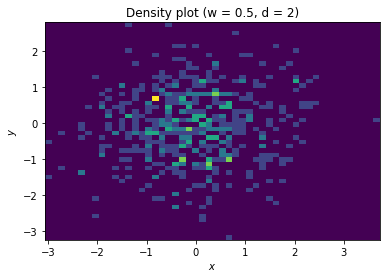

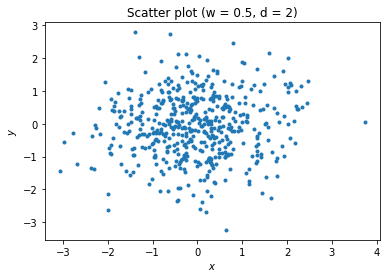

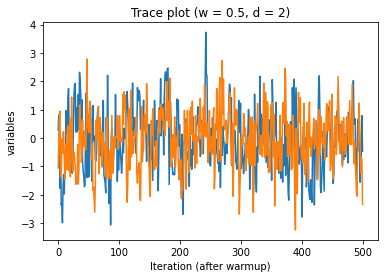

In [7]:
#2
def make_plots_2d(theta,thin=10):
    """Make diagnostics plots for MCMC (assume 2D)."""
    plt.hist2d(theta[::thin, 0],theta[::thin, 1], 50, density=True)
    plt.title('Density plot (w = {}, d = {})'.format(w, d))
    plt.xlabel(r'$x$')
    plt.ylabel(r'$y$')
    plt.show()

    plt.scatter(theta[::thin, 0],theta[::thin, 1], marker = '.')
    plt.title('Scatter plot (w = {}, d = {})'.format(w, d))
    plt.xlabel(r'$x$')
    plt.ylabel(r'$y$')
    plt.show()
    
    plt.plot(theta[::thin])
    plt.title('Trace plot (w = {}, d = {})'.format(w, d))
    plt.xlabel(r'Iteration (after warmup)')
    plt.ylabel(r'variables')
    plt.show()

make_plots_2d(theta)

w = 10, d = 2:
Acceptance rate: 0.0198


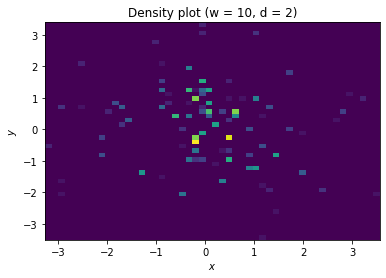

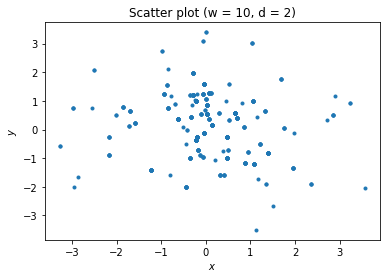

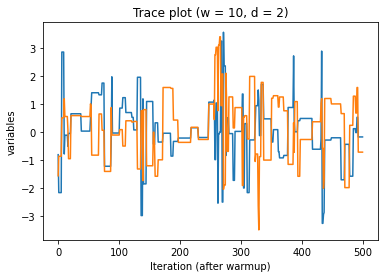

In [8]:
#3
w = 10
print('w = {}, d = {}:'.format(w, d))
theta = d_mhsample(np.zeros(d), 10000, target, lambda theta: propose_draws(theta, w))
theta = theta[len(theta)//2:]
make_plots_2d(theta)

w = 0.5, d = 5:
Acceptance rate: 0.5984


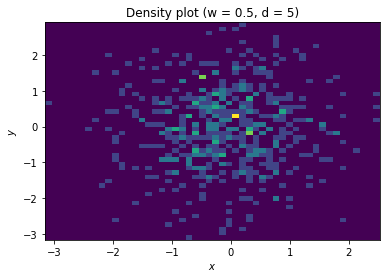

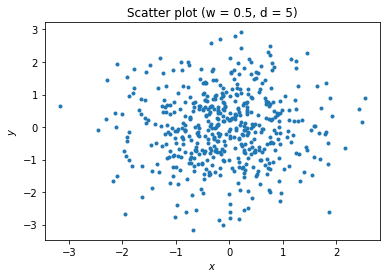

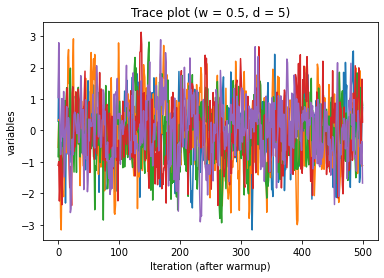

w = 10, d = 5:
Acceptance rate: 0.0


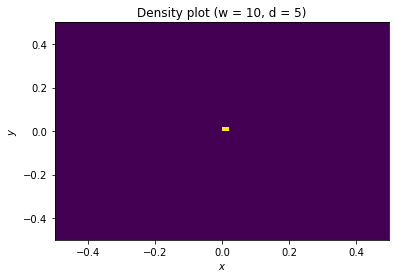

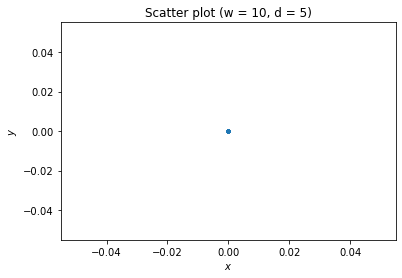

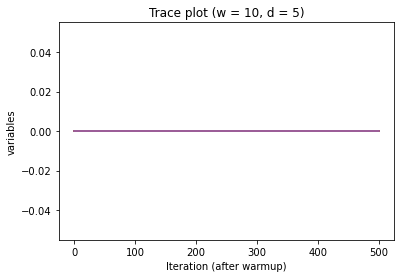

In [9]:
#4 Repeat for D=5
w = 0.5
d = 5
print('w = {}, d = {}:'.format(w, d))
theta = d_mhsample(np.zeros(d), 10000, target, lambda theta: propose_draws(theta, w))
theta = theta[len(theta)//2:]
make_plots_2d(theta)

w = 10
d = 5
print('w = {}, d = {}:'.format(w, d))
theta = d_mhsample(np.zeros(d), 10000, target, lambda theta: propose_draws(theta, w))
theta = theta[len(theta)//2:]
make_plots_2d(theta)

## 4. Sampling a multimodal distribution, convergence checking

In this exercise we consider Metropolis-Hastings sampling from a two-dimensional unnormalised target distribution
$$ P^*(\theta; R) = \sum_{i=1}^5 \exp\left( -\frac{1}{2} (\theta-\mu_i)^T (\theta - \mu_i) \right) $$
with $\mu_1 = (0, 0), \mu_2 = (R, R), \mu_3 = (R, -R), \mu_4 = (-R, R), \mu_5 = (-R, -R)$. Here $R$ denotes a parameter that specifies the spread of the modes of the distribution.

1. Plot a contour plot of $\log P^*(\theta; R)$ for $R = 6$. *Hint*: We already provide the code for making a contour plot, you only need to write the code for the target log density.
2. Write a Metropolis-Hastings sampler for the target using $q(\theta' ; \theta) = \mathcal{N}(\theta'; \; \theta, I_2)$ as the proposal and run it to obtain 10000 samples.
3. Plot a scatter plot of the samples and compare it to the contour plot. Is the sampler exploring the density well?
4. Start several chains from different initial values and compare the results. Do the chains converge?
5. Try repeating the experiment with $R=3$.
6. Try repeating the experiment with $R=100$ using the same initial points as with $R=3$.
7. Try to get the sampler to explore the density for $R=6$. Try running the sampler for longer, changing the proposal, ...

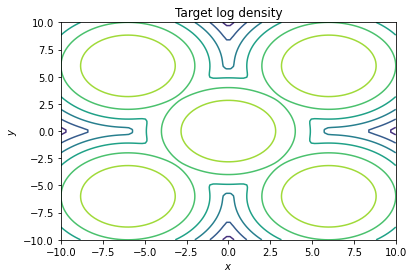

In [10]:
%matplotlib inline
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import scipy.special as scs

npr.seed(41)

def target(theta, R):
    """Target log density."""
    means = np.array([[0, 0],[R, R],[-R,R],[R,-R],[-R,-R]])
    K = means.shape[0]
    logp = -0.5*np.sum((theta[np.newaxis,:]-means)**2, 1)
    return scs.logsumexp(logp)

# 1
R = 6.0
x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
for i, x_ in enumerate(x):
    for j, y_ in enumerate(y):
        Z[i,j] = target(np.array([x_, y_]), R)
        
plt.contour(X, Y, Z)
plt.title('Target log density')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.show()

Acceptance rate: 0.555


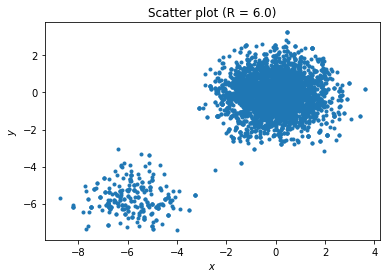

In [11]:
# 2 and 3

def plot_scatter_2d(theta,thin=1):
    """Scatter plot of MCMC points (assume D=2)."""
    plt.plot(theta[:,0], theta[:,1], '.')
    plt.xlabel(r'$x$')
    plt.ylabel(r'$y$')        
    plt.title('Scatter plot (R = {})'.format(R))
    plt.xlabel(r'$x$')
    plt.ylabel(r'$y$')
    plt.show()
    
# Note that we reuse the MH sampler from the previous exercise

R = 6.0
theta = d_mhsample(np.array([0.0, 0.0]), 10000, lambda theta: target(theta, R), lambda theta: theta+npr.randn(2))
theta = theta[len(theta)//2:]
plot_scatter_2d(theta)

Acceptance rate: 0.6137


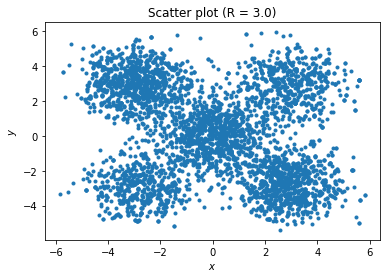

In [12]:
# 5

R = 3.0
theta = d_mhsample(np.array([0.0, 0.0]), 10000, lambda theta: target(theta, R), lambda theta: theta+npr.randn(2))
theta = theta[len(theta)//2:]
plot_scatter_2d(theta)

Acceptance rate: 0.5453


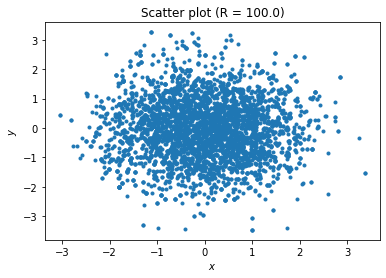

In [13]:
# 6

R = 100.0
theta = d_mhsample(np.array([0.0, 0.0]), 10000, lambda theta: target(theta, R), lambda theta: theta+npr.randn(2))
theta = theta[len(theta)//2:]
plot_scatter_2d(theta)

Acceptance rate: 0.5517


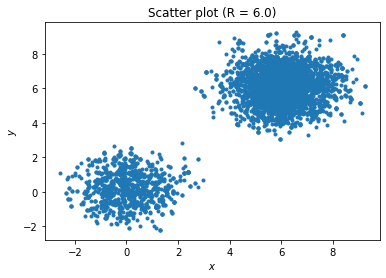

Acceptance rate: 0.29505


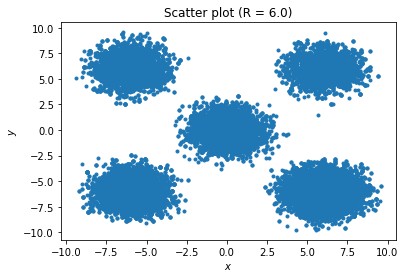

In [14]:
# 7

R = 6.0
npr.seed(42)

# Original MCMC hyperparameters
theta = d_mhsample(np.array([0.0, 0.0]), 10000, lambda theta: target(theta, R), lambda theta: theta+npr.randn(2))
theta = theta[len(theta)//2:]
plot_scatter_2d(theta)

# Increase step length and iteration count, this should work here
theta = d_mhsample(np.array([0.0, 0.0]), 100000, lambda theta: target(theta, R), lambda theta: theta+2*npr.randn(2))
theta = theta[len(theta)//2:]
plot_scatter_2d(theta)